Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [108]:
import logging
from itertools import combinations
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import networkx as nx
from tqdm import tqdm
from icecream import ic

logging.basicConfig(level=logging.DEBUG)
INPUT = 'russia.csv'

In [109]:
path = 'cities/' + INPUT
CITIES = pd.read_csv(path, header=None, names=['name', 'lat', 'lon'])
DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)))
for c1, c2 in combinations(CITIES.itertuples(), 2):
    DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km
CITIES.head()

,name,lat,lon
0,Abakan,53.72,91.43
1,Achinsk,56.28,90.50
2,Almetyevsk,54.90,52.31
3,Angarsk,52.57,103.91
4,Arkhangelsk,64.57,40.53


## Lab2 - TSP

https://www.wolframcloud.com/obj/giovanni.squillero/Published/Lab2-tsp.nb

In [110]:
def tsp_cost(tsp):
    assert tsp[0] == tsp[-1]
    assert set(tsp) == set(range(len(CITIES)))

    tot_cost = 0
    for c1, c2 in zip(tsp, tsp[1:]):
        tot_cost += DIST_MATRIX[c1, c2]
    return tot_cost

## First Greedy Algorithm

In [111]:
def greedy_tsp():
    visited = np.full(len(CITIES), False)
    dist = DIST_MATRIX.copy()
    city = 0
    visited[city] = True
    tsp = list()
    tsp.append(int(city))
    #FROM the starting city, that is the first city, we will find the closest city and add it to the path, iteratively
    # until all cities are visited
    steps = 0
    while not np.all(visited):
        steps+=1
        dist[:, city] = np.inf
        closest = np.argmin(dist[city])
        logging.debug(
            f"step: {CITIES.at[city,'name']} -> {CITIES.at[closest,'name']} ({DIST_MATRIX[city,closest]:.2f}km)"
        )
        visited[closest] = True
        city = closest
        tsp.append(int(city))
    logging.debug(
        f"step: {CITIES.at[tsp[-1],'name']} -> {CITIES.at[tsp[0],'name']} ({DIST_MATRIX[tsp[-1],tsp[0]]:.2f}km)"
    )

    tsp_greedy = tsp.copy()

    logging.info(f"result: Found a path of {len(tsp)} steps, total length {tsp_cost(tsp):.2f}km")
    return tsp_greedy, steps

## Helper functions

In [112]:
#GENOTYPE: a list of integers, each representing a city
#PHENOTYPE: the path that visits all cities in the order specified by the genotype

def genotype_to_phenotype(genotype):
    return [CITIES.at[city, 'name'] for city in genotype]

def random_genotype():
    return np.random.permutation(len(CITIES))

# NEW TSP COST FUNCTION, no need to check if the path is closed
def tsp_cost(tsp):
    assert set(tsp) == set(range(len(CITIES)))
    #assert no duplicates
    assert len(tsp) == len(set(tsp))
    
    tot_cost = 0
    for c1, c2 in zip(tsp, tsp[1:]):
        tot_cost += DIST_MATRIX[c1, c2]
    tot_cost += DIST_MATRIX[tsp[-1], tsp[0]]
    return tot_cost

#MUTATION FUNCTIONS

def single_swap_mutation(genotype):
    i, j = np.random.choice(len(genotype), 2, replace=False)
    genotype[i], genotype[j] = genotype[j], genotype[i]
    return genotype

def multi_swap_mutation(genotype, p=0.8):
    first = True
    if first or np.random.rand() < p:
        i, j = np.random.choice(len(genotype), 2, replace=False)
        genotype[i], genotype[j] = genotype[j], genotype[i]
        first = False
    return genotype

def print_tsp(tsp, top_cost):
    logging.info(f"result: Found a path of {len(tsp)} steps, total length {top_cost:.2f}km")

    # Print path
    for city, closest in zip(tsp, tsp[1:]):
        logging.debug(
            f"step: {CITIES.at[city,'name']} -> {CITIES.at[closest,'name']} ({DIST_MATRIX[city,closest]:.2f}km)"
        )
    logging.debug(
        f"step: {CITIES.at[tsp[-1],'name']} -> {CITIES.at[tsp[0],'name']} ({DIST_MATRIX[tsp[-1],tsp[0]]:.2f}km)"
    )

#For Greedy2
def arrange_segments(segments: list[tuple]) -> list[tuple]:
    connections = {}
    for u, v in segments:
        connections.setdefault(u, []).append(v)
        connections.setdefault(v, []).append(u)

    ordered_segments = [segments[0]]
    current = segments[0][1]

    while len(ordered_segments) < len(segments):
        next_city = connections[current].pop()
        connections[next_city].remove(current)
        ordered_segments.append((current, next_city))
        current = next_city

    return ordered_segments

def segments_to_path(segments: list[tuple]) -> list[int]:
    return [segment[0] for segment in segments]

def finalize_segment_tsp(segments: list[tuple], degrees: list[int]) -> list[tuple]:
    assert len(degrees) == len(CITIES), f"len(degrees)={len(degrees)} != len(CITIES)={len(CITIES)}"
    assert all(degree > 0 for degree in degrees), f"degrees={degrees} should be all > 0"

    endpoints = [index for index, degree in enumerate(degrees) if degree == 1]
    assert len(endpoints) == 2, f"len(endpoints)={len(endpoints)} != 2"
    segments.append((endpoints[0], endpoints[1]))

    return segments



## Greedy 2 : Shortest segment

In [113]:
def greedy2():
    # Create a list of all possible city pairs with their distances
    city_pairs = list(combinations(range(len(CITIES)), 2))
    city_pairs = [((i, j), DIST_MATRIX[i, j]) for i, j in city_pairs]

    # Initialize the union-find structure and other variables
    union_find = nx.utils.UnionFind()
    tour = []
    city_degrees = [0] * len(CITIES)
    steps = 0
    # Flag to check if all segments are processed
    segments_processed = False
    while not segments_processed:
        steps += 1
        # Find and remove the shortest segment
        shortest_segment = min(city_pairs, key=lambda x: x[1])
        city_pairs.remove(shortest_segment)
        shortest_segment = shortest_segment[0]

        # Check if the cities are in different sets and have less than 2 connections
        different_sets = union_find[shortest_segment[0]] != union_find[shortest_segment[1]]
        less_than_two_connections = city_degrees[shortest_segment[0]] < 2 and city_degrees[shortest_segment[1]] < 2
        if different_sets and less_than_two_connections:
            # Union the sets and add the segment to the tour
            union_find.union(*shortest_segment)
            tour.append(shortest_segment)
            # Update the degrees of the cities
            city_degrees[shortest_segment[0]] += 1
            city_degrees[shortest_segment[1]] += 1

        segments_processed = len(city_pairs) == 0

    # Finalize the tour by closing the cycle and arranging the segments
    tour = finalize_segment_tsp(tour, city_degrees)
    tour = arrange_segments(tour)

    # Convert the segments to a list of cities and calculate the total cost
    tour = segments_to_path(tour)
    return tour, tsp_cost(tour), steps


Christofied algorithm

## Hill Climbing with Mutation and Simulated Annealing


Simulated Annealing

In [114]:
def simulated_annealing(solution, full_history, bettering_history, nsteps, mutation_prob):
    tweak = multi_swap_mutation
    top_cost = -tsp_cost(solution)
    last_bettering = 0
    top_solution = solution.copy()
    for step in range(int(nsteps)):
        new_solution = tweak(solution.copy(), mutation_prob)
        new_cost = tsp_cost(new_solution)
        current_cost = tsp_cost(solution)
        full_history.append(-new_cost)
        
        # if solution is better, accept it
        if new_cost < current_cost:
            solution = new_solution
            bettering_history.append(-new_cost)
            last_bettering = step
        # else, accept it with a certain probability
        else:
            temperature = max(0.01, 1 - len(full_history) / nsteps)
            acceptance_probability = np.exp((current_cost - new_cost) / temperature)
            if acceptance_probability > np.random.rand():
                solution = new_solution
        
        bettering_history.append(-tsp_cost(solution))
        
        # Stop if no improvement in the last nsteps/10 steps
        if step - last_bettering > nsteps / 10:
            print(f"No improvement in the last {nsteps // 10} steps. Stopping early.")
            break
    
    if top_cost < -tsp_cost(solution):
        top_solution = solution.copy()
        top_cost = -tsp_cost(solution)
    
    return full_history, bettering_history, top_cost, last_bettering, top_solution

Plotting Function

In [115]:
def plot_history(history, bettering_history, labels: list):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    ax.plot(history, label=labels[0])
    ax.plot(bettering_history, label=labels[1])
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Cost")
    ax.legend()
    plt.show()
    


## Genetic Algorithm


In [116]:
def inver_over_crossover(parent1: np.ndarray, parent2: np.ndarray):
    child = []
    n = len(parent1)
    visited = set()
    
    # Select a random starting index in parent1
    start = np.random.randint(0, n - 1)
    child.append(int(parent1[start]))
    visited.add(int(parent1[start]))
    # Find the corresponding city in parent2 and select the next one
    idx2 = np.where(parent2 == parent1[start])[0][0]
    idx2 = (idx2 + 1) % n
    child.append(int(parent2[idx2]))
    visited.add(int(parent2[idx2]))
    # Find index of parent2[idx2] in parent1
    idx1 = np.where(parent1 == parent2[idx2])[0][0]
    # Preserve edge of the first parent => meaning from parent1[idx1] to parent1[start]
    #  but inverse order of the cities
    index = ( idx1 + 1 ) % n
    idx1 = (idx1 - 1) % n
    while parent1[idx1] not in visited:
        child.append(int(parent1[idx1]))
        visited.add(int(parent1[idx1]))
        idx1 = (idx1 - 1) % n
    
    # Complete set of cities, preserving parent1
    while parent1[index] not in visited:
        child.append(int(parent1[index]))
        visited.add(int(parent1[index]))
        index = (index + 1) % n

    assert len(child) == n
    assert set(child) == set(range(n))

    #Return the child as a numpy array
    return np.array(child)

In [117]:
#try inver over crossover
"""
parent1 = random_genotype()
parent2 = random_genotype()
child = inver_over_crossover(parent1, parent2)
"""

'\nparent1 = random_genotype()\nparent2 = random_genotype()\nchild = inver_over_crossover(parent1, parent2)\n'

Generational (population_size, population_size+1or2, population_size)

In [118]:
def genetic_algorithm(nsteps, population_size, starting_solution):
    population = []
    if starting_solution is not None:
        population.append(starting_solution)
        for _ in range(population_size):
            temp = starting_solution.copy()
            population.append(single_swap_mutation(temp))
    else:
        population = [random_genotype() for _ in range(population_size)]
    
    top_cost = tsp_cost(min(population, key=tsp_cost))
    last_bettering = 0
    print("Starting best cost: ", top_cost)
    genetic_operator = [multi_swap_mutation, inver_over_crossover]
    for step in tqdm(range(nsteps)):
        # Adjust mutation and crossover probabilities
        if step - last_bettering > 10:
            mutation_prob = 0.9
            crossover_prob = 0.1
        else:
            mutation_prob = 0.1
            crossover_prob = 0.9

        # Choose the genetic operator
        operator = np.random.choice(genetic_operator, p=[mutation_prob, crossover_prob])

        # Select the correct number of parents (1 parent for mutation, 2 parents for crossover)
        if operator == multi_swap_mutation:
            nparents = 1
        else:
            nparents = 2

        # Parent selection (Tournament selection)
        parents = []
        for _ in range(nparents):
            tournament_indices = np.random.choice(len(population), 10, replace=False)
            tournament = [np.copy(population[i]) for i in tournament_indices]
            best = min(tournament, key=tsp_cost)
            parents.append(best)

        # Generate offspring
        if operator == multi_swap_mutation:
            # 10 mutated versions of the parent
            offspring = [operator(parents[0].copy()) for _ in range(10)]
            population.extend(offspring)
        else:
            offspring = operator(*parents)
            population.append(offspring)  # Add to population

        # Survivor selection (deterministic replacement)
        population = sorted(population, key=tsp_cost)[:population_size]

        # Update best cost
        new_top_cost = tsp_cost(population[0])

        # Update last bettering
        if new_top_cost < top_cost:
            top_cost = new_top_cost
            last_bettering = step

        # Stop if no improvement in the last nsteps/10 steps
        if step - last_bettering > nsteps / 10:
            print(f"No improvement in the last {nsteps // 10} steps. Stopping early.")
            break

    top_cost = min(tsp_cost(ind) for ind in population)
    tsp = min(population, key=tsp_cost)    

    return tsp, top_cost, last_bettering

## Running all the algos


In [119]:
#Run the genetic algorithm
print("**GENETIC ALGORITHM**")
nsteps = 10000
tsp, top_cost, last_bettering = genetic_algorithm(nsteps, 100, None)
print_tsp(tsp, top_cost)
cost_genetic = top_cost
steps_genetic = last_bettering



**GENETIC ALGORITHM**
Starting best cost:  297695.0558382861


100%|██████████| 10000/10000 [02:22<00:00, 70.19it/s]
INFO:root:result: Found a path of 167 steps, total length 75122.89km
DEBUG:root:step: Tobolsk -> Neftekamsk (878.06km)
DEBUG:root:step: Neftekamsk -> Izhevsk (107.05km)
DEBUG:root:step: Izhevsk -> Nizhnekamsk (160.60km)
DEBUG:root:step: Nizhnekamsk -> Kazan (169.59km)
DEBUG:root:step: Kazan -> Cheboksary (124.86km)
DEBUG:root:step: Cheboksary -> Novocheboksarsk (15.59km)
DEBUG:root:step: Novocheboksarsk -> Saransk (261.73km)
DEBUG:root:step: Saransk -> Syzran (244.73km)
DEBUG:root:step: Syzran -> Dimitrovgrad (139.76km)
DEBUG:root:step: Dimitrovgrad -> Orenberg (462.47km)
DEBUG:root:step: Orenberg -> Orenburg (0.37km)
DEBUG:root:step: Orenburg -> Artyom (5598.96km)
DEBUG:root:step: Artyom -> Vladivostok (34.21km)
DEBUG:root:step: Vladivostok -> Nakhodka (87.36km)
DEBUG:root:step: Nakhodka -> Yuzhno‐Sakhalinsk (901.85km)
DEBUG:root:step: Yuzhno‐Sakhalinsk -> Petropavlovsk‐Kamchatskiy (1321.54km)
DEBUG:root:step: Petropavlovsk‐Kamchat

**SIMULATED ANNEALING**


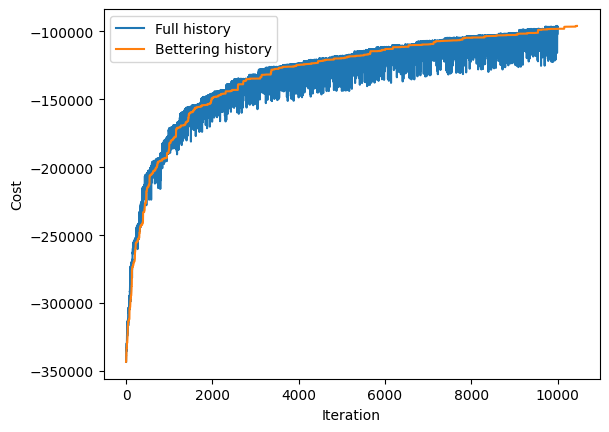

INFO:root:result: Found a path of 167 steps, total length 96075.14km
DEBUG:root:step: Khimki -> Mytishchi (18.28km)
DEBUG:root:step: Mytishchi -> Korolyov (5.74km)
DEBUG:root:step: Korolyov -> Shchyolkovo (12.70km)
DEBUG:root:step: Shchyolkovo -> Shakhty (923.56km)
DEBUG:root:step: Shakhty -> Novoshakhtinsk (20.74km)
DEBUG:root:step: Novoshakhtinsk -> Novocherkassk (38.39km)
DEBUG:root:step: Novocherkassk -> Rostov‐na‐Donu (35.01km)
DEBUG:root:step: Rostov‐na‐Donu -> Bataysk (11.52km)
DEBUG:root:step: Bataysk -> Ryazan (832.12km)
DEBUG:root:step: Ryazan -> Novomoskovsk (115.09km)
DEBUG:root:step: Novomoskovsk -> Lipetsk (188.29km)
DEBUG:root:step: Lipetsk -> Tula (220.86km)
DEBUG:root:step: Tula -> Serpukhov (81.18km)
DEBUG:root:step: Serpukhov -> Podolsk (56.28km)
DEBUG:root:step: Podolsk -> Lyubertsy (35.54km)
DEBUG:root:step: Lyubertsy -> Zheleznodorozhnyy (11.95km)
DEBUG:root:step: Zheleznodorozhnyy -> Balashikha (6.96km)
DEBUG:root:step: Balashikha -> Zelenograd (44.16km)
DEBUG:ro

In [120]:
#Run the simulated annealing
print("**SIMULATED ANNEALING**")
full_history, bettering_history, top_cost, last_bettering, tsp = simulated_annealing(random_genotype(), [], [], 10000, 0.9)
plot_history(full_history, bettering_history, ["Full history", "Bettering history"])
print_tsp(tsp, -top_cost)
cost_simulated = top_cost
steps_simulated = last_bettering

In [121]:

#Run Greedy2
print("**GREEDY2**")
tsp, top_cost, steps = greedy2()
print_tsp(tsp, top_cost)
cost_greedy2 = top_cost
steps_greedy2 = steps


**GREEDY2**


INFO:root:result: Found a path of 167 steps, total length 39758.48km
DEBUG:root:step: Orenberg -> Orenburg (0.37km)
DEBUG:root:step: Orenburg -> Novotroitsk (232.42km)
DEBUG:root:step: Novotroitsk -> Orsk (21.66km)
DEBUG:root:step: Orsk -> Magnitogorsk (247.00km)
DEBUG:root:step: Magnitogorsk -> Zlatoust (199.76km)
DEBUG:root:step: Zlatoust -> Miass (33.88km)
DEBUG:root:step: Miass -> Chelyabinsk (87.20km)
DEBUG:root:step: Chelyabinsk -> Kopeysk (14.72km)
DEBUG:root:step: Kopeysk -> Kamensk‐Uralskiy (145.80km)
DEBUG:root:step: Kamensk‐Uralskiy -> Yekaterinburg (95.20km)
DEBUG:root:step: Yekaterinburg -> Pervouralsk (40.19km)
DEBUG:root:step: Pervouralsk -> Nizhniy Tagil (112.49km)
DEBUG:root:step: Nizhniy Tagil -> Perm (220.37km)
DEBUG:root:step: Perm -> Berezniki (159.92km)
DEBUG:root:step: Berezniki -> Norilsk (1844.90km)
DEBUG:root:step: Norilsk -> Novyy Urengoy (612.52km)
DEBUG:root:step: Novyy Urengoy -> Noyabrsk (328.30km)
DEBUG:root:step: Noyabrsk -> Nizhnevartovsk (254.53km)
DE

In [122]:
#Run Greedy1
tsp_greedy, steps = greedy_tsp()
cost_greedy1 = tsp_cost(tsp_greedy)
steps_greedy1 = steps


DEBUG:root:step: Abakan -> Krasnoyarsk (276.58km)
DEBUG:root:step: Krasnoyarsk -> Achinsk (161.71km)
DEBUG:root:step: Achinsk -> Kemerovo (296.59km)
DEBUG:root:step: Kemerovo -> Leninsk‐Kuznetskiy (74.76km)
DEBUG:root:step: Leninsk‐Kuznetskiy -> Prokopyevsk (91.87km)
DEBUG:root:step: Prokopyevsk -> Novokuznetsk (30.63km)
DEBUG:root:step: Novokuznetsk -> Biysk (187.38km)
DEBUG:root:step: Biysk -> Barnaul (132.82km)
DEBUG:root:step: Barnaul -> Novosibirsk (194.50km)
DEBUG:root:step: Novosibirsk -> Tomsk (206.90km)
DEBUG:root:step: Tomsk -> Seversk (14.97km)
DEBUG:root:step: Seversk -> Rubtsovsk (613.13km)
DEBUG:root:step: Rubtsovsk -> Omsk (647.47km)
DEBUG:root:step: Omsk -> Tobolsk (475.40km)
DEBUG:root:step: Tobolsk -> Tyumen (200.98km)
DEBUG:root:step: Tyumen -> Kurgan (189.69km)
DEBUG:root:step: Kurgan -> Kopeysk (236.87km)
DEBUG:root:step: Kopeysk -> Chelyabinsk (14.72km)
DEBUG:root:step: Chelyabinsk -> Miass (87.20km)
DEBUG:root:step: Miass -> Zlatoust (33.88km)
DEBUG:root:step: Zl

In [123]:
# Insert in file results.txt a row with this format:
#  filename=INPUT, Greedy1=cost_greedy1, steps_greedy1, Greedy2=cost_greedy2, steps_greedy2, Simulated=cost_simulated, steps_simulated, Genetic=cost_genetic, steps_genetic

with open("results.txt", "a") as f:
    f.write(f"filename={INPUT}, Greedy1={cost_greedy1}, {steps_greedy1}, Greedy2={cost_greedy2}, {steps_greedy2}, Simulated={cost_simulated}, {steps_simulated}, Genetic={cost_genetic}, {steps_genetic}\n")
